# Equilibrium Binding of Transcription Factors
> If you know TF concentrations, binding site affinities, and cooperativities, can you predict probabilities for each configuration?

- toc: true
- comments: true
- hide: false

[With extensive help from [Jeremy A. Owen](https://www.mit.edu/~jaowen/)]

In [78]:
#collapse
# imports
import string
from collections import defaultdict
import itertools
from random import choice, random
from scipy.stats import bernoulli, norm, lognorm, expon as exponential
from scipy.stats import rv_discrete, rv_continuous

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import colorConverter, TABLEAU_COLORS
# colorConverter.to_rgba('mediumseagreen', alpha=.5)
import plotly.graph_objects as go

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['hatch.linewidth'] = 0.3

from IPython.display import display, HTML

# brew install ghostscript
# brew install pdf2svg
# pip install seqlogo
import seqlogo

import requests
from xml.etree import ElementTree

import json

ln = np.log
exp = np.exp

In [85]:
#collapse
# distribution plotting utilities
def is_discrete(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_discrete)
    else: return isinstance(dist, rv_discrete)

def is_continuous(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_continuous)
    else: return isinstance(dist, rv_continuous)

def plot_distrib(distrib, title=None):

    fig, ax = plt.subplots(1, 1)

    if is_continuous(distrib):
        x = np.linspace(distrib.ppf(0.001),
                        distrib.ppf(0.999), 1000)
        ax.plot(x, distrib.pdf(x), 'k-', lw=0.4)

    elif is_discrete(distrib):
        x = np.arange(distrib.ppf(0.01),
                      distrib.ppf(0.99))
        ax.plot(x, distrib.pmf(x), 'bo', ms=2, lw=0.4)

    r = distrib.rvs(size=1000)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=200)

    if title: ax.set_title(title)
    fig_style_2(ax)
    return ax

def fig_style_2(ax):
    for side in ["right","top","left"]: ax.spines[side].set_visible(False)
    ax.get_yaxis().set_visible(False)

In [204]:
#collapse
# functions for plotting DNA

base_colors = {'A': 'Lime', 'G': 'Gold', 'C': 'Blue', 'T':'Crimson'}

def print_bases(dna): return HTML(''.join([f'<span style="color:{base_colors[base]};font-size:1.5rem;font-weight:bold;font-family:monospace">{base}</span>' for base in dna]))

complement = {'A':'T', 'T':'A', 'C':'G', 'G':'C', 'a':'t', 't':'a', 'c':'g', 'g':'c'}

def reverse_complement(dna):
    list_repr = [complement[base] for base in dna[::-1]]
    if type(dna) == list: return list_repr
    else: return ''.join(list_repr)

def reverse_complement_pwm(pwm):
    return pwm[::-1, [base_index.index(complement[base]) for base in base_index]]

## Single TF

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}$$

There exist two mathematical formalisms to describe the probabilities of molecular configurations at equilibrium: thermo and <span style="color:CadetBlue">kinetics</span>. In the <span style="color:CadetBlue">kinetics</span> formalism, the system transits between configurational states according to rate parameters contained in differential equations, which can describe not just the system's equilibrium but also its _trajectory_ towards it, or the kinetics of non-equilibrium systems. In the <span style="color:CornflowerBlue ">thermodynamics</span>/statistical mechanics formalism, we posit that a system will occupy configurations with lower energy, and use the Boltzmann distribution to estimate the proportion of time the system spends in each state, at equilibrium. The <span style="color:CornflowerBlue ">thermodynamics</span> formalism is limited in that it only describes equilibrium, but it achieves this with fewer, more intuitive parameters. 

We'll derive an expression for the probability of a single TFBS' occupancy with both formalisms, but proceed with the thermodynamic description for more elaborate configurations. It will become clear why that is preferable.

### Kinetics

Most derivations of the probability of single TFBS occupancy at equilibrium employ a <span style="color:CadetBlue">kinetics</span> formalism, so we'll walk through that first, and then explore the analog in the <span style="color:CornflowerBlue ">thermodynamics</span> description. In the <span style="color:CadetBlue">kinetics</span> description, the parameters are **rates**. 

$$ \mathrm{TF} + \mathrm{TFBS} \underset{\koff}{\overset{\kon}{\rightleftarrows}} \mathrm{TF\colon TFBS} $$

The natural rates are the rate of TF binding $\kon$ and unbinding $\koff$. Equilibrium is reached when binding and unbinding are balanced:

$$\frac{d[\mathrm{TF\colon TFBS}]}{dt} = k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}] - k_{\mathrm{off}}[\mathrm{TF\colon TFBS}] = 0 \text{ at equilibrium}$$
$$k_{\mathrm{on}}[\mathrm{TF}]_{\mathrm{eq}}[\mathrm{TFBS}]_{\mathrm{eq}} = k_{\mathrm{off}}[\mathrm{TF\colon TFBS}]_{\mathrm{eq}}$$
$$\text{(dropping eq subscript) }[\mathrm{TF\colon TFBS}] = \frac{k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}]}{k_{\mathrm{off}}} = \frac{[\mathrm{TF}][\mathrm{TFBS}]}{k_{d}}$$

where $k_{d} = \frac{\koff}{\kon}$ is called the [dissociation constant](https://en.wikipedia.org/wiki/Dissociation_constant) (or equilibrium constant). We'd like to determine the probability of finding the TFBS occupied, i.e. the fraction of time it spends in the bound state. That fraction is $\frac{[\mathrm{bound}]}{([\mathrm{unbound}] + [\mathrm{bound}])} = \frac{[\mathrm{TF\colon TFBS}]}{([\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}])}$. Define the denominator as $[\mathrm{TFBS}]_{0} = [\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}]$ so that $[\mathrm{TFBS}] = [\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}]$ and substitute: 

$$[\mathrm{TF\colon TFBS}] = \frac{[\mathrm{TF}]([\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}])}{k_{d}}$$
$$[\mathrm{TF\colon TFBS}](k_d + [\mathrm{TF}]) = [\mathrm{TF}][\mathrm{TFBS}]_{0}$$
$$\frac{[\mathrm{TF\colon TFBS}]}{[\mathrm{TFBS}]_{0}} = \frac{[\mathrm{TF}]}{k_d + [\mathrm{TF}]}$$

> Note: We could also ask for this expression in terms of $[\mathrm{TF}]_0 = [\mathrm{TF}] + [\mathrm{TF\colon TFBS}]$ however, since we're considering a single TFBS, $[\mathrm{TF\colon TFBS}]$ is at most 1, and so $[\mathrm{TF}]_0 \approx [\mathrm{TF}]$. In instances of ligand-receptor binding in which that approximation cannot be made, the fraction bound is a messy quadratic. [Derivation here](https://www.med.upenn.edu/ostaplab/assets/user-content/documents/simpleligandbindingequations.pdf). 


### Thermodynamics

In the <span style="color:CornflowerBlue ">thermodynamics</span> description, the parameters are Gibbs free energies $\Delta G$. Let's follow the derivation from [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/) (pp. 242) and consider the number microstates underlying each of the of bound and unbound macrostates, and their energies.

In order to count microstates, we imagine distributing $L$ TF molecules across a space-filling lattice with $\Omega$ sites. The energy of a TF in solution is $\varepsilon_{\mathrm{solution}}$ and the energy of a bound TF is $\varepsilon_{\mathrm{bound}}$. $\beta$ is the constant $1/k_b T$ where $k_b$ is Boltzmann's constant and $T$ is the temperature. 

<img src="../images/equilibrium_TFs/single_TF_thermodynamic.png" width=1000/>
<!-- 

<table style="float:left; width:100%">
    <tr style="text-align:center; font-size:1.5rem; font-family:serif"><td>State</td><td>Energy</td><td>Multiplicity</td><td>Weight</td></tr>
    <tr><td><img src='../images/equilibrium_TFs/naked.png'  width=300/></td>
        <td>$A \cdot A_s$</td>
        <td>$\frac{\Omega!}{(\Omega - A)!A!} \approx \frac{\Omega^{A}}{A!}$</td>
        <td>$\frac{\Omega^{A}}{A!} \cdot e^{-\beta \left[ A \cdot A_s \right]}$</td>
    </tr>
    <tr><td><img src='../images/equilibrium_TFs/A.png'  width=300/></td>
        <td>$(A - 1) A_s + A_b$</td>
        <td>$\frac{\Omega!}{(\Omega - (A - 1))!(A-1)!B!} \approx \frac{\Omega^{A-1}}{(A-1)!}$</td>
        <td>$\frac{\Omega^{A-1}}{(A-1)!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b \right]}$</td>
    </tr>
</table> -->

In our case, the number of microstates in the unbound macrostate is $\frac{\Omega !}{L!(\Omega -L)!}\approx \frac{\Omega^L}{L!}$ and they each have energy $L \cdot \varepsilon_s$. The number of microstates in the bound macrostate is $\frac{\Omega !}{(L-1)!(\Omega -(L+1))}\approx \frac{\Omega^{(L-1)}}{(L-1)!}$ and they each have energy $(L-1) \varepsilon_s + \varepsilon_b$.

The [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution) describes the probability of a microstate as a function of its energy: $p(E_i) = e^{-\beta E_i}/Z$ where $Z$ is the "partition function" or simply $\sum_i e^{-\beta E_i}$ the sum of the weights of the microstates, which normalizes the distribution. In our case:


$$Z(L,\Omega)=\left(\colorbox{LightCyan}{$ \frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$}\right) + \left(\colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}\right)$$

With that expression in hand, we can express the probability of the bound macrostate, $p_b$:

$$p_b=\frac{ \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}}{\colorbox{LightCyan}{$\frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$} + \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}} \cdot \color{DarkRed}\frac{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}}{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}} \color{black} = \frac{(L/\Omega)e^{- \beta \Delta \varepsilon}}{1+(L/\Omega)e^{- \beta \Delta \varepsilon}}  $$

Where we have defined $\Delta \varepsilon = \varepsilon_b - \varepsilon_s$. $L/\Omega$ is really just a dimensionless TF concentration, which we'll hand-wave as being equivalent to $[\mathrm{TF}]$, which leaves us with an expression suspiciously similar to the one we derived from the <span style="color:CadetBlue">kinetics</span> formalism:

$$p_b = \frac{[\mathrm{TF}]e^{-\beta \Delta \varepsilon}}{1+[\mathrm{TF}]e^{-\beta \Delta \varepsilon}} \cdot \color{DarkRed}\frac{e^{\beta \Delta \varepsilon}}{e^{\beta \Delta \varepsilon}} \color{black} = \frac{[\mathrm{TF}]}{e^{\beta \Delta \varepsilon}+[\mathrm{TF}]}$$

From which we recapitulate an important correspondence between <span style="color:CadetBlue">kinetics</span> and <span style="color:CornflowerBlue ">thermodynamics</span> at equilibrium: $ k_d = e^{\beta \Delta \varepsilon} = e^{\Delta \varepsilon / k_bT} $ more commonly written for different units as $k = e^{-\Delta G / RT}$.

The takeaway is that both the <span style="color:CadetBlue">kinetics</span> and <span style="color:CornflowerBlue ">thermodynamics</span> formalisms produce an equivalent expression for the probabilities of each of the bound and unbound configurations, parameterized respectively by $k_d$ and $\Delta G$.







**References**: 
- [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/)
- [Thermodynamics of Biological Processes](https://doi.org/10.1016/B978-0-12-381268-1.00014-8)
- [Statistical Mechanics of Binding](http://www.bio-physics.at/wiki/index.php?title=Statistical_Mechanics_of_Binding)

### Sample Values

In order to compute probabilities like $p_b$, we need concrete TF concentrations $[\mathrm{TF}]$ and binding affinities (either $k_d$ or $\Delta G$). What are typical intranuclear TF concentrations and binding affinities?

#### Concentrations

A typical human cell nucleus has diameter 6μm, so spherical volume = $\frac{4}{3}\pi r^3 = \frac{4}{3}\pi (3\mathrm{\mu m})^3 \approx 113\mathrm{\mu m}^3$. ([MBoC](https://en.wikipedia.org/wiki/Cell_nucleus#:~:text=the%20average%20diameter%20of%20the%20nucleus%20is%20approximately%206%20micrometres%20(%CE%BCm).)

A typical expressed TF has a per-cell copy number range from $10^3$ - $10^6$. ([BioNumbers](http://book.bionumbers.org/what-are-the-copy-numbers-of-transcription-factors/#:~:text=Their%20concentration%20depends%20strongly%20on,106%20in%20mammalian%20cells.))


In [14]:
copy_number_range = [1e3, 1e6]
nuclear_volume = 113
N_A = 6.02214076e23

def copy_number_to_concentration(copy_number): return (copy_number / N_A) / (nuclear_volume * (1e3 / 1e18))

lower_end_molar = copy_number_to_concentration(copy_number_range[0])
upper_end_molar = copy_number_to_concentration(copy_number_range[1])

lower_end_nanomolar = lower_end_molar / 1e-9
upper_end_nanomolar = upper_end_molar / 1e-9

print('If TF copy numbers range from 1,000-1,000,000, then TF concentrations range from', str(round(lower_end_nanomolar))+'nM', 'to', str(round(upper_end_nanomolar))+'nM')


If TF copy numbers range from 1,000-1,000,000, then TF concentrations range from 15nM to 14695nM


We might also like a distribution over this range. Let's posit a lognormal, where $10^3$ and $10^6$ are the 3σ from the mean, which is $10^{4.5}$. Then $\sigma = 10^{0.5}$

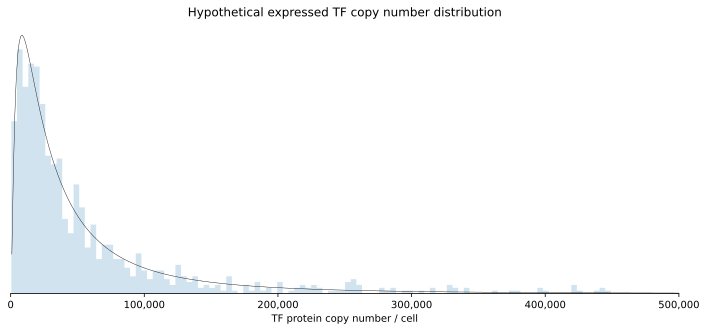

In [89]:
#collapse
# define a distribution over TF copy numbers
# Note: the lognormal is defined with base e, so we need to take some natural logs on our base 10 expression.
TF_copy_number_distrib = lognorm(scale=10**4.5, s=np.log(10**0.5))
ax = plot_distrib(TF_copy_number_distrib, title='Hypothetical expressed TF copy number distribution')
ax.set_xlim(left=0, right=5e5)
ax.set_xlabel('TF protein copy number / cell')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

def TF_nanomolar_concentrations_sample(TFs):
    return dict(zip(TFs, (copy_number_to_concentration(TF_copy_number_distrib.rvs(len(TFs)))*1e9).astype(int)))

#### Affinities

What are typical TF ΔG's of binding? How about the $\koff$ rates and half lives?
- We can use the prior knowledge that dissociation constants should be in the nanomolar regime ([BioNumbers](http://book.bionumbers.org/what-are-the-copy-numbers-of-transcription-factors/#:~:text=%20the%20cellular%20concentrations%20of%20transcription%20factors%20are%20often%20comparable%20to%20the%20kds%20of%20these%20proteins%20for%20dna%20binding.)). 
- We can use the relation that $\Delta G = -k_b T \cdot \ln(k_d)$ (Plugging in 310°K (human body temp) and the Boltzmann constant $k_b$ in kcal/Mol)
- We use the approximation that $\kon$ is ~$10^5 / $ Molar $ \times $ sec  ([Wittrup](https://mitpress.mit.edu/books/quantitative-fundamentals-molecular-and-cellular-bioengineering))

In [15]:
T = 310
k_b = 3.297623483e-24 * 1e-3  ## cal/K * kcal/cal
kbT = k_b*T*N_A
kbT  ## in 1/Mol -- an unusual format

k_on = 1e5

def nanomolar_kd_from_kcal_ΔG(ΔG): return exp(-ΔG/kbT) * 1e9
def kcal_ΔG_from_nanomolar_kd(K_d): return -kbT*ln(K_d*1e-9)
def k_off_from_nanomolar_kd(k_d): return (k_d*1e-9) * k_on
def half_life_from_kd(k_d): return ln(2) / ((k_d*1e-9) * k_on)

In [91]:
#collapse
# compute statistics from kds
nanomolar_kds = pd.Series([1, 10, 100, 1000])

affinity_grid = pd.DataFrame()
affinity_grid['$k_d$'] = nanomolar_kds
affinity_grid['$\Delta G$'] = nanomolar_kds.apply(kcal_ΔG_from_nanomolar_kd)
affinity_grid['$\kon$'] = '1e5 / (M * s)'
affinity_grid['$\koff$'] = nanomolar_kds.apply(k_off_from_nanomolar_kd)
affinity_grid['$t_{1/2}$'] = pd.to_timedelta(nanomolar_kds.apply(half_life_from_kd), unit='s')

affinity_grid = affinity_grid.set_index('$k_d$')
affinity_grid

,$\Delta G$,$\kon$,$\koff$,$t_{1/2}$
$k_d$,,,,
1,12.757685,1e5 / (M * s),0.0001,0 days 01:55:31.471805599
10,11.340164,1e5 / (M * s),0.0010,0 days 00:11:33.147180560
100,9.922644,1e5 / (M * s),0.0100,0 days 00:01:09.314718056
1000,8.505123,1e5 / (M * s),0.1000,0 days 00:00:06.931471806


We learn that an order of magnitude residence time difference results from just 1.4 extra kcal/Mol, and that TF half lives range from about 5s to about 2h. Let's once again posit a distribution of affinities to sample from (defined on $k_d$): 

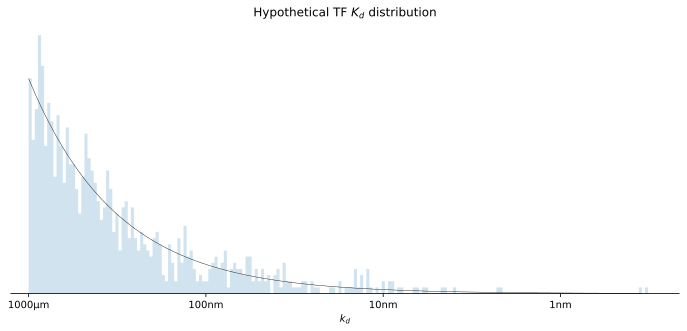

In [92]:
#collapse
# define a distribution over TF Kd's / ΔG's
TF_affinity_min = 6       ## define exponential distribution in log10 space
TF_affinity_spread = 0.5

TF_affinity_distrib = exponential(loc=TF_affinity_min, scale=TF_affinity_spread)

ax = plot_distrib(TF_affinity_distrib, title="Hypothetical TF $K_d$ distribution")

ax.set_xlim(left=5.9)
ax.set_xlabel('$k_d$')
plt.xticks([6,7,8,9], ['1000μm', '100nm', '10nm', '1nm'])

def TF_Kd_sample(n=1): return 10**(-TF_affinity_distrib.rvs(n))

def TF_ΔG_sample(n=1): return kcal_ΔG_from_nanomolar_kd(10**(-TF_affinity_distrib.rvs(n)+9))

With those concrete TF concentrations and dissociation constants, we can finally plot our function $p_b = \frac{[\mathrm{TF}]}{e^{\beta \Delta \varepsilon}+[\mathrm{TF}]}$.

In [93]:
@np.vectorize
def fraction_bound(TF, ΔG):
    '''TF in nanomolar'''
    return TF / (TF + nanomolar_kd_from_kcal_ΔG(ΔG))

In [103]:
#collapse
# plot fraction bound as a function of concentration and binding energy

TF_concentration_array = np.logspace(1, 5)
ΔG_array = np.logspace(*np.log10([8, 13]))
TF_concs_matrix, ΔG_matrix = np.meshgrid(TF_concentration_array, ΔG_array)

z_data = pd.DataFrame(fraction_bound(TF_concs_matrix, ΔG_matrix), index=ΔG_array, columns=TF_concentration_array).rename_axis('ΔG').T.rename_axis('[TF]')

fig = go.Figure(data=[go.Surface(x=TF_concentration_array.astype(int).astype(str), y=ΔG_array.round(1).astype(str), z=z_data.values)])

fig.update_layout(
    title='',
    autosize=False,
    width=700,
    margin=dict(r=20, l=10, b=10, t=10),
    scene = dict(
        xaxis_title='[TF]',
        yaxis_title='ΔG',
        zaxis_title='Pb'),
    scene_camera = dict(eye=dict(x=-1, y=-1.8, z=1.25)))

fig.update_traces(showscale=False)

# config = dict({'scrollZoom': False})
# fig.show(config = config)

# display(fig)
HTML(fig.to_html(include_plotlyjs='cdn', include_mathjax=False))

(Note that both $[\mathrm{TF}]$ and $k_d$ are plotted in log space, but $p_b$ is linear.)

## Multiple TFs: Direct Cooperativity & Competition

Suppose now that two TFs bind adjacent segments of DNA in such a way that the binding of either facilitates (or hinders) the binding of the other. We call this direct cooperativity (and competition). We'll focus first on cooperativity.

### Cooperativity

As before, the statistical mechanics formalism entails enumerating the configurations, their multiplicities, and their energies. We'll call the TFs A and B. We'll denote their counts as $A$ and $B$. The energy of a TF in solution will once more be $A_s$ and bound to its cognate TFBS $A_b$. The energy of cooperativity will be $C_{AB}$.

<table style="float:left; width:100%">
    <tr style="text-align:center; font-size:1.5rem; font-family:serif"><td>State</td><td>Energy</td><td>Multiplicity</td><td>Weight</td></tr>
    <tr><td><img src='../images/equilibrium_TFs/naked.png'  width=300/></td>
        <td>$A \cdot A_s + B \cdot B_s$</td>
        <td>$\frac{\Omega!}{(\Omega - A - B)!A!B!} \approx \frac{\Omega^{A+B}}{A!B!}$</td>
        <td>$\frac{\Omega^{A+B}}{A!B!} \cdot e^{-\beta \left[ A \cdot A_s + B \cdot B_s \right]}$</td>
    </tr>
    <tr><td><img src='../images/equilibrium_TFs/A.png'  width=300/></td>
        <td>$(A - 1) A_s + A_b + B \cdot B_s$</td>
        <td>$\frac{\Omega!}{(\Omega - (A - 1) - B)!(A-1)!B!} \approx \frac{\Omega^{A+B-1}}{(A-1)!B!}$</td>
        <td>$\frac{\Omega^{A+B-1}}{(A-1)!B!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + B \cdot B_s \right]}$</td>
    </tr>
    <tr><td><img src='../images/equilibrium_TFs/B.png'  width=300/></td>
        <td>$A \cdot A_s + (B - 1) B_s + B_b$</td>
        <td>$\frac{\Omega!}{(\Omega - A - (B - 1))!A!(B-1)!} \approx \frac{\Omega^{A+B-1}}{A!(B-1)!}$</td>
        <td>$\frac{\Omega^{A+B-1}}{A!(B-1)!} \cdot e^{-\beta \left[ A \cdot A_s + (B - 1) B_s + B_b \right]}$</td>
    </tr>
    <tr><td><img src='../images/equilibrium_TFs/AB.png' width=300 /></td>
        <td>$(A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB}$</td>
        <td>$\frac{\Omega!}{(\Omega - (A - 1) - (B-1))!(A-1)!(B-1)!} \approx \frac{\Omega^{A+B-2}}{(A-1)!(B-1)!}$</td>
        <td>$\frac{\Omega^{A+B-2}}{(A-1)!(B-1)!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB} \right]}$</td>
    </tr>
</table>

The partition function is the sum of the weights:

$$ Z = \frac{\Omega^{A+B}}{A!B!} \cdot e^{-\beta \left[ A \cdot A_s + B \cdot B_s \right]} +
\frac{\Omega^{A+B-1}}{(A-1)!B!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + B \cdot B_s \right]} +
\frac{\Omega^{A+B-1}}{A!(B-1)!} \cdot e^{-\beta \left[ A \cdot A_s + (B - 1) B_s + B_b \right]} +
\frac{\Omega^{A+B-2}}{(A-1)!(B-1)!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB} \right]}$$

Which we can greatly simplify by multiplying the entire expression by the reciprocal of the "base state" weight, $\color{DarkRed}\frac{A!B!}{\Omega^{A+B}} \cdot e^{\beta \left[ A \cdot A_s + B \cdot B_s \right]}$, normalizing that weight to 1:

$$ Z = 1 +
\frac{A}{\Omega} \cdot e^{-\beta \left[ A_b-A_s \right]} +
\frac{B}{\Omega} \cdot e^{-\beta \left[ B_b-B_s \right]} +
\frac{A \cdot B}{\Omega^2} \cdot e^{-\beta \left[ A_b-A_s+B_b-B_s+C_{AB} \right]}$$

Taking the definition $[A] = A/\Omega$ and $\Delta G_A = A_b-A_s$ produces: 

$$ Z = 1 +
[A] e^{-\beta \left[ \Delta G_A \right]} +
[B] e^{-\beta \left[ \Delta G_B \right]} +
[A][B] e^{-\beta \left[ \Delta G_A+\Delta G_B+C_{AB} \right]}$$

Then the probability of any state is just the weight of that state (scaled by the weight of the base state) divided by the partition function expression $Z$. 

From the above, we notice the form of the expression for the weight of a configuration of N TFBSs: 

$$ p_{\mathrm{config}} =  \prod_{i \in \, \mathrm{bound \,TBFS}} \left( [\mathrm{TF}_{\mathrm{cognate}(i)}] \cdot e^{-\beta \left[ \Delta G_i + \sum_j c_{ij} \right]}  \right) / Z$$

For [numerical stability](https://en.wikipedia.org/wiki/Log_probability#:~:text=accuracy.%20the%20use%20of%20log%20probabilities%20improves%20numerical%20stability%2C%20when%20the%20probabilities%20are%20very%20small%2C%20because%20of%20the%20way%20in%20which%20computers%20approximate%20real%20numbers.), we take the log of the unnormalized probability (that is, the weight) of configurations:

$$ \log(\tilde{p}_{\mathrm{config}}) = \sum_{i \in \, \mathrm{bound \,TBFS}} \left( \log([\mathrm{TF}_{\mathrm{cognate}(i)}]) - \beta \left[ \Delta G_i + \sum_j c_{ij} \right]  \right) $$


In [17]:
#collapse
# define log_P_config()
β = 1/kbT  ## kbT was in in 1/Mol

def log_P_config(config, TF_conc, TFBSs, cooperativities):

    logP = 0

    for i, tfbs in TFBSs[config.astype(bool)].iterrows():

        cooperativity_sum = 0
        if i in cooperativities:
            cooperativity_sum = sum([C_AB for tfbs_j, C_AB in cooperativities[i].items() if config[tfbs_j] == 1])

        logP = sum([np.log(TF_conc[tfbs.TF]*1e-9) + β*(tfbs.dG + cooperativity_sum)])  ## the sign is flipped here, because our ΔG's of binding are positive above.

    return logP

### Competition

Incorporating competition into our thermodynamic model is slightly more subtle than cooperativity, because we can imagine two types of competition
- Two TFs which may both bind DNA at adjacent sites, causing a free energy penalty due to some unfavorable interaction. 
- Two TFs with overlapping DNA binding sites, which cannot physically be bound at the same time. 

In the former case, the expression for $p_\mathrm{config}$ we had written before suffices, with values of $C_{AB}$ having both signs to represent cooperativity and competition. Nominally, the latter case also fits this formalism if we allow $C_{AB}$ to reach $-\infty$, but that would cause us headaches in the implementation. Instead, the weights of all those configurations which are not physical attainable, due to "strict" competitive binding between TFs vying for overlapping binding sites, are merely omitted from the denominator $Z$.

**References**: 
- [Transcriptional regulation by the numbers: models](https://pubmed.ncbi.nlm.nih.gov/15797194/)
- [Thermodynamic State Ensemble Models of cis-Regulation](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002407)

### Sample cooperativity values

In order to compute concrete probabilities of configurations, accounting for cooperativity and competition, we will need concrete energies. We'll take $C_{AB}$ to be distributed exponentially with a mean at 2.2kcal/Mol. ([Forsén & Linse](https://www.sciencedirect.com/science/article/pii/S096800040089115X?via%3Dihub)). 

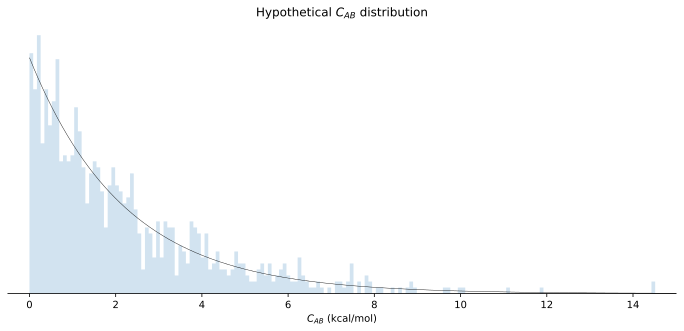

In [22]:
#collapse
# define a distribution of cooperativities
cooperativity_mean_ΔG = 2.2

cooperativity_distrib = exponential(scale=cooperativity_mean_ΔG)

ax = plot_distrib(cooperativity_distrib, title="Hypothetical $C_{AB}$ distribution")

ax.set_xlim(left=-0.5,right=15)
ax.set_xlabel('$C_{AB}$ (kcal/mol)')

def C_AB_sample(n=1): return cooperativity_distrib.rvs(n)

In [23]:
#collapse
# sample that distribution for cooperativities between binding sites
def sample_cooperativities(TFBSs):

    cooperativities = defaultdict(lambda: dict())

    for i, tfbs_i in TFBSs.iterrows():
        for j, tfbs_j in TFBSs.iterrows():
            if i < j:
                if 7 <= abs(tfbs_i.start - tfbs_j.start) <= 10:
                    cooperativities[i][j] = cooperativities[j][i] = C_AB_sample()[0]
                elif abs(tfbs_i.start - tfbs_j.start) < 7:
                    cooperativities[i][j] = cooperativities[j][i] = -C_AB_sample()[0]

    return dict(cooperativities)

Let's check our derivation (and our implementation) of $p_\mathrm{config}$ by comparing it to our direct computation of $p_b$ from [§1. Single TF](https://alexlenail.me/back_of_my_envelope/2022/01/12/equilibrium_TFs.html#Single-TF).

In [30]:
#collapse
# define create_environment()
len_TFBS=10

def create_environment(len_DNA=1000, num_TFs=10, num_TFBS=20, len_TFBS=10):
    # TFBSs is a dataframe with columns 'TF_name', 'start', 'dG'

    TFs = list(string.ascii_uppercase[:num_TFs])  ## TF names are just letters from the alphabet
    TF_conc = TF_nanomolar_concentrations_sample(TFs)
    TFBSs = pd.DataFrame([{'TF': choice(TFs), 'start': int(random()*(len_DNA-len_TFBS)), 'dG': TF_ΔG_sample()[0]} for _ in range(num_TFBS)]).sort_values(by='start').reset_index(drop=True)
    cooperativities = sample_cooperativities(TFBSs)

    return TFs, TF_conc, TFBSs, cooperativities


In [35]:
#collapse
# define draw_config() for plotting
def draw_config(TFBSs, TF_conc, cooperativities, config=None, len_DNA=1000):

    if config is None: config = [0]*len(TFBSs)

    TF_colors = dict(zip(list(TF_conc.keys()), list(TABLEAU_COLORS.values())))

    plt.rcParams['figure.figsize'] = [12, 0.5+np.sqrt(len(TFs))]
    fig, axs = plt.subplots(ncols=2, sharey=True, gridspec_kw={'width_ratios': [4, 1]})
    genome_track_ax = draw_genome_track(axs[0], config, TFBSs, cooperativities, TF_colors, len_DNA=len_DNA)
    conc_plot_ax = draw_concentration_plot(axs[1], TF_conc, TF_colors)

    return genome_track_ax, conc_plot_ax

def draw_concentration_plot(conc_plot_ax, TF_conc, TF_colors):

    conc_plot_ax.barh(range(len(TF_conc.keys())), TF_conc.values(), align='edge', color=list(TF_colors.values()), alpha=0.9)
    for p in conc_plot_ax.patches:
        conc_plot_ax.annotate(str(p.get_width())+'nm', (p.get_width() + 10*(p.get_width()>0), p.get_y() * 1.02), fontsize='x-small')

    conc_plot_ax.axes.get_yaxis().set_visible(False)
    conc_plot_ax.axes.get_xaxis().set_visible(False)
    conc_plot_ax.set_frame_on(False)

    return conc_plot_ax

def draw_genome_track(genome_track_ax, config, TFBSs, cooperativities, TF_colors, len_DNA=1000):

    genome_track_ax.set(ylabel='TFs', ylim=[-1, len(TF_colors.keys())+1], yticks=range(len(TFs)), yticklabels=TFs, xlabel='Genome', xlim=[0, len_DNA])

    for i, tfbs in TFBSs.iterrows():
        tfbs_scale = np.clip(0.01*np.exp(tfbs.dG-7), 0, 1)
        genome_track_ax.add_patch(Rectangle((tfbs.start, TFs.index(tfbs.TF)), len_TFBS, 0.8, fc=TF_colors[tfbs.TF], alpha=tfbs_scale))
        genome_track_ax.add_patch(Rectangle((tfbs.start, TFs.index(tfbs.TF)), len_TFBS, 0.1*tfbs_scale, fc=TF_colors[tfbs.TF], alpha=1))
        genome_track_ax.annotate(str(int(tfbs.dG))+'kcal/Mol', (tfbs.start, TFs.index(tfbs.TF)-0.3), fontsize='xx-small')
        genome_track_ax.add_patch(Polygon([[tfbs.start+2, TFs.index(tfbs.TF)], [tfbs.start+5,TFs.index(tfbs.TF)+0.8],[tfbs.start+8, TFs.index(tfbs.TF)]], fc=TF_colors[tfbs.TF], alpha=config[i]))

    cm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-3, vmax=3), cmap=matplotlib.cm.PiYG)

    for i, rest in cooperativities.items():
        for j, C_AB in rest.items():
            tfbs_i = TFBSs.iloc[i]
            tfbs_j = TFBSs.iloc[j]

            xa = tfbs_i.start+(len_TFBS/2)
            xb = tfbs_j.start+(len_TFBS/2)

            ya = TFs.index(tfbs_i.TF)
            yb = TFs.index(tfbs_j.TF)

            genome_track_ax.plot([xa, (xa+xb)/2, xb], [ya+0.9, max(ya, yb)+1.2, yb+0.9], color=cm.to_rgba(C_AB))

    genome_track_ax.grid(axis='y', lw=0.1)
    genome_track_ax.set_frame_on(False)

    return genome_track_ax

In [36]:
def enumerate_configs(TFBSs): return list(map(np.array, itertools.product([0,1], repeat=len(TFBSs))))

def p_configs(TFBSs, TF_conc, cooperativities):

    configs = enumerate_configs(TFBSs)
    weights = []

    for config in configs:

        weights.append(np.exp(log_P_config(config, TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities)))

    return list(zip(configs, np.array(weights) / sum(weights)))


p_bound (prev method): 	 0.5517750016034638
p_config (new method): 	 [(array([0]), 0.4482249983965356), (array([1]), 0.5517750016034644)]


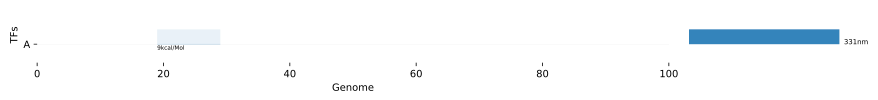

In [37]:
#collapse
TFs, TF_conc, TFBSs, cooperativities = create_environment(len_DNA=100, num_TFs=1, num_TFBS=1)

print('p_bound (prev method): \t', fraction_bound(TF_conc['A'], TFBSs.iloc[0].dG))
print('p_config (new method): \t', p_configs(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities={}))

genome_track_ax, conc_plot_ax = draw_config(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities, len_DNA=100)
plt.tight_layout()

With that sanity check, let's now consider the scenario of two transcription factors with cooperative binding, and compute the probabilities of each of the 4 configurations:

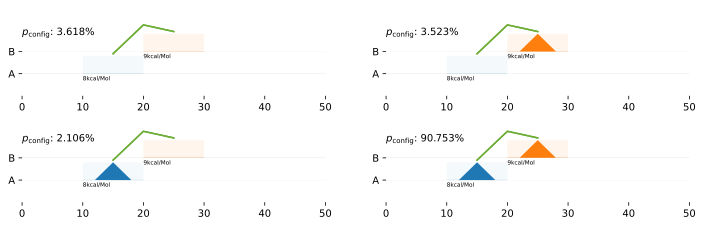

In [38]:
#collapse
# Create cooperative environment
len_DNA =  100
TFs = ['A', 'B']
TF_conc = TF_nanomolar_concentrations_sample(TFs)
TFBSs = pd.DataFrame([{'TF': 'A', 'start': 10, 'dG': TF_ΔG_sample()[0]}, {'TF': 'B', 'start': 20, 'dG': TF_ΔG_sample()[0]}])
cooperativities = {0: {1: 2}, 1: {0: 2}}

TF_colors = dict(zip(list(TF_conc.keys()), list(TABLEAU_COLORS.values())))

plt.rcParams['figure.figsize'] = [12, 2*(0.8+int(np.sqrt(len(TFs))))]
fig, axs = plt.subplots(nrows=2, ncols=2)

for ax, (config, p) in zip([ax for row in axs for ax in row], p_configs(TFBSs=TFBSs, TF_conc=TF_conc, cooperativities=cooperativities)):

    draw_genome_track(ax, config, TFBSs, cooperativities, TF_colors, len_DNA=50)
    ax.set(ylabel='', xlabel='')
    ax.set_title('$p_\mathrm{config}$: '+str(round(p*100,3))+'%', y=1.0, pad=-28, loc='left', fontsize=10)


### Low-Affinity binding

In reality, transcription factors' binding sites are not so discretely present or absent: transcription factors may bind anywhere along the DNA polymer, with an affinity dependent on the interaction surface provided by the sequence of nucleotides at each locus. There are a variety of approaches to model the sequence-to-affinity function for each TF. The simplest is to consider each nucleotide independently, and list the preferences for each nucleotide at each sequential position in a matrix. This type of "mono-nucleotide position weight matrix" (PWM) model is commonly used, and frequently represented by a "sequence logo" plot.

I have curated a list of PWMs for ~1000 human TFs from the [HumanTFs](http://humantfs.ccbr.utoronto.ca/) database.

In [262]:
tfdb = pd.read_json('../../AChroMap/data/processed/TF.json', orient='index').dropna(subset=['pwm'])

As an example, consider the Transcription Factor [**SPI1**](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SPI1) / [**PU.1**](https://www.uniprot.org/uniprot/P17947), who's PWM looks like:

In [263]:
#collapse
# plot PWMs
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

fp = FontProperties(family="Arial", weight="bold")
globscale = 1.35
LETTERS = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }

def letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=base_colors[letter],  transform=t, alpha=1-0.8*(y<0))
    if ax != None:
        ax.add_artist(p)
    return p

def plot_pwm(pwm, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(4,2))

    x = 1
    maxi = 0
    for row in pwm:

        y = 0
        for freq, base in sorted(zip(row, base_index)):
            if freq > 0:
                letterAt(base, x,y, freq, ax=ax)
                y += freq

        x += 1
        maxi = max(maxi, y)

    plt.xticks(range(1,x))
    plt.xlim((0, x))
    plt.ylim((0, maxi))
    for side in ["right","top","left", 'bottom']: ax.spines[side].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    return ax

def plot_energy_pwm(abs_pwm, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))

    x = 1
    maxi = 0
    mini = 0
    for row in abs_pwm:

        y = 0
        for dG, base in sorted(zip(row, base_index)):
            if dG > 0:
                letterAt(base, x,y, dG, ax=ax)
                y += dG

        maxi = max(maxi, y)

        y = -0.1
        for dG, base in sorted(zip(row, base_index), reverse=True):
            if dG < 0:
                y += dG
                letterAt(base, x,y, abs(dG), ax=ax)

        mini = min(mini, y)

        x += 1

    plt.xticks(range(1,x))
    plt.xlim((0, x))
    plt.ylim((mini, maxi))
    plt.tight_layout()

    for side in ["right","top","left", 'bottom']: ax.spines[side].set_visible(False)
    ax.set_ylabel('ΔΔG/RT',  weight='bold')
    ax.get_xaxis().set_visible(False)
    return ax

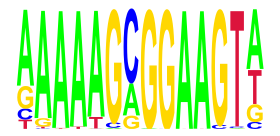

In [264]:
ax = plot_pwm(tfdb.loc['SPI1'].pwm)

This representation of this matrix visualizes the probability of the occurrence of a base at a particular position in SPI1 binding sites.

These PWM models can be fit from any experiment measuring PU.1 binding to a large variety of sequences. In this case, we're looking at a model fit from High-Throughput SELEX data (HT-SELEX), but other models for PU.1 binding are catalogued at its [entry](http://humantfs.ccbr.utoronto.ca/myTFPageUniversal.php?user=&eID=ENSG00000066336&dbd=&submit_param=submit_value) in the HumanTFs database. 

An information-theoretic interpretation of this matrix produces a method to score sequences for possible binding sites. The information content of a base $j$ at a particular position $i$ is 

$$IC_{ij} = -p_{ij} * log_2(\frac{p_{ij}}{\mathrm{bg}_j})$$

where $\mathrm{bg}_j$ is the background frequency of nucleotide $j$ in the (in our case, human) genome. Negative $IC_{ij}$ values are flattened to 0.

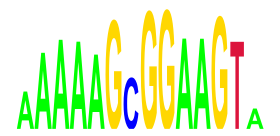

In [265]:
# background frequencies of A, C, G, T in the human genome are not each 0.25...
bg = [0.2955, 0.2045, 0.2045, 0.2955]

def freq_pwm_to_info_pwm(freq_pwm):
    return [[max(pos * np.log2((pos+1e-8)/bg[i]),0) for i, pos in enumerate(row)] for row in freq_pwm]

ax = plot_pwm(freq_pwm_to_info_pwm(tfdb.loc['SPI1'].pwm))

Unfortunately, both of these formalisms miss the biophysical interpretation we have carried throughout our analysis thus far. We can coax a biophysical interpretation from these PWMs as follows (following the approach from [Foat, Morozov, Bussemaker, 2006](https://academic.oup.com/bioinformatics/article/22/14/e141/228084)): 

If we consider the nucleotides independently, then the ratio of equilibrium binding to a given nucleotide $j$ versus the highest-affinity nucleotide $\mathrm{best}$ at each position is related to the difference in energies of binding:

$$ \frac{[TF:N_j]}{[TF:N_{best}]} = \frac{K_{a_j}}{K_{a_{best}}} = \exp \{\Delta G_j -  \Delta G_{best} \} $$

With this expression, we can compute the energy of binding of a TF to a sequence relative to that TF's energy of binding to its _best_ sequence of nucleotides. However, we need to know an absolute energy of binding to anchor this relative measure. 

In [274]:
#collapse
# define make_energy_pwm()
def make_energy_pwm(pwm):
    pwm = np.array(pwm)+1e-2
    pwm = pwm/np.expand_dims(np.sum(pwm, axis=1), axis=1)
    energy_pwm = np.array([[kbT*ln(fraction/max(row)) for fraction in row] for row in pwm])
    return energy_pwm

tfdb['energy_pwm'] = tfdb.pwm.apply(make_energy_pwm)

We can visualize this "energy PWM" as well. Visualizing energies of particular bases relative to SPI1's best sequence does not produce a visual representation that's easy to reason about:

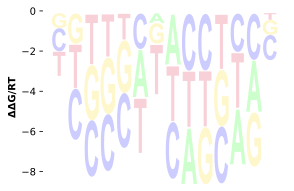

In [276]:
ax = plot_energy_pwm(tfdb.loc['SPI1'].energy_pwm)

We can rescale this matrix to the average sequence:

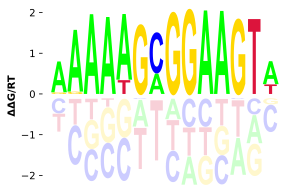

In [277]:
SPI1_energy_pwm = tfdb.loc['SPI1'].energy_pwm

ax = plot_energy_pwm(SPI1_energy_pwm - np.expand_dims(SPI1_energy_pwm.mean(axis=1), axis=1))

However, the ideal rescaling of this PWM would indicate whether each nucleotide contributes positively or negatively towards the energy of binding. After all, SPI1 likely doesn't bind the "average" sequence -- which is to say it's off rate is higher than it's on rate. 

We chose SPI1 / PU.1 as our prototype in part because its absolute binding energies to various sequences have been measured, allowing us to anchor our relative energies PWM model. [Pham et al](https://academic.oup.com/nar/article/41/13/6391/1122398#83605257) measured PU.1 binding to a variety of high-affinity sequences by microscale thermophoresis and recorded a $k_d$ of 156nm for the best one. 

In [278]:
SPI1_best_nanomolar_kd = 156
SPI1_best_ΔG = kcal_ΔG_from_nanomolar_kd(SPI1_best_nanomolar_kd)
SPI1_best_ΔG

9.648885505793956

However, the question remains of how to allocate those ~9.6 kcal/mol across the 14 bases of the SPI1 motif. The naive option is to uniformly spread the binding energy across the bases (9.6/14). Instead, we'll distribute it proportionally to the variance at each position to capture the intuition that the flanking nucleotides contribute less. 

In [279]:
#collapse
# define make_abs_pwm()

def make_abs_pwm(pwm, ΔG_of_best_sequence):
    '''each base is allocated the absolute value of the variation at that position'''

    energy_range = abs(np.min(pwm, axis=1))
    energy_fractional_allocation = energy_range/energy_range.sum()

    energy_per_base = ΔG_of_best_sequence * energy_fractional_allocation
    abs_pwm = pwm + np.expand_dims(energy_per_base, axis=1)

    return abs_pwm

In [280]:
SPI1_energy_pwm_scaled = make_abs_pwm(SPI1_energy_pwm, SPI1_best_ΔG)

<AxesSubplot:ylabel='ΔΔG/RT'>

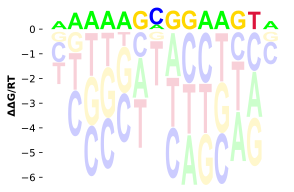

In [281]:
plot_energy_pwm(SPI1_energy_pwm_scaled)

At last we have a visual representation of of a mono-nucleotide sequence preference model which captures our intuitions about the energetics of TF binding. 

For a restricted set of TFs with high-quality HT-SELEX data, [Rube et al](https://www.biorxiv.org/content/10.1101/2021.06.30.450414v1) produced relative energy PWMs with higher accuracy in the low-affinity regime. SPI1 is among that privileged set, so we'll take a look at  that PWM for comparison. 

In [282]:
#collapse
# define
def load_probound_pwm_from_json(TF_id):

    with open(f'/Users/alex/Documents/AChroMap/data/raw/ProBound/json/{id}.json') as json_file:
        json_data = json.load(json_file)

    mononucleotide_model = json_data['coefficients']['bindingModes'][0]['mononucleotide']
    pwm = np.reshape(mononucleotide_model, (len(mononucleotide_model)//4,4))
    base_index = json_data['modelSettings']['letterOrder']

    return pwm, base_index

<AxesSubplot:ylabel='ΔΔG/RT'>

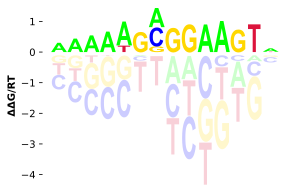

In [286]:
SPI1_id = 13165
probound_SPI1_pwm, base_index = load_probound_pwm_from_json(SPI1_id)
probound_SPI1_pwm_scaled = make_abs_pwm(probound_SPI1_pwm, SPI1_best_ΔG)
plot_energy_pwm(reverse_complement_pwm(probound_SPI1_pwm_scaled))

In [232]:
def get_hg38_bases(chrom, start, stop):

    url = f'http://genome.ucsc.edu/cgi-bin/das/hg38/dna?segment={chrom}:{start},{stop}'

    response = requests.get(url)

    root = ElementTree.fromstring(response.content)
    dna = root.find('SEQUENCE').find('DNA').text.replace('\n', '')
    return dna

In [233]:
chrom = 'chr11'
start = '47378300'
stop = '47378900'

dna = get_hg38_bases(chrom, start, stop)

In [235]:
dna

'ggtactcacaggggggacgaggggaaacccttccattttgcacgcctgtaacatccagccgggctccgagtcggtcagatcccctgcctcggtgggggccaatgcagagcccctcaggatggggtgccccgtcaggggctggacggtcgtggggcgggtgcagggctcaggcctgccccctgagctacaggagccctgggtgagccccctcccttgacattgcagggccagcacaagttcctgattttatcgaagggcctgccgctgggagatagtccccttggggtgacatcaccgccccaacccgtttgcataaatctcttgcgctacatacaggaagtctctggccggctggggcaggtggtgctcaaagggctggcctgggaagccatggggtccaggccccctgcccagaggaagctgggactgagagggatgactttgggggctaagctggggagggaggatgggagggagaacgtgtagctctgccacaccactgggaggcttttgctctaacccaacaaatgcctgcttcttttgagatccctatgtagccaacagtcacctcattggggtcagagctggaaggggtggcctc'

In [237]:
base_index = {'a':0,'c':1,'g':2,'t':3,'A':0,'C':1,'G':2,'T':3}
binding_energies_at_starting_positions = []

for i in range(len(dna)-len(abs_pwm)):
    cumulative_energy_of_binding = 0
    for j, row in enumerate(abs_pwm):
        cumulative_energy_of_binding += row[base_index[dna[i+j]]]

    binding_energies_at_starting_positions.append(cumulative_energy_of_binding)

In [243]:
binding_energies_at_starting_positions = pd.Series(np.where(binding_energies_at_starting_positions > 0, binding_energies_at_starting_positions, np.nan))

<AxesSubplot:xlabel='index', ylabel='0'>

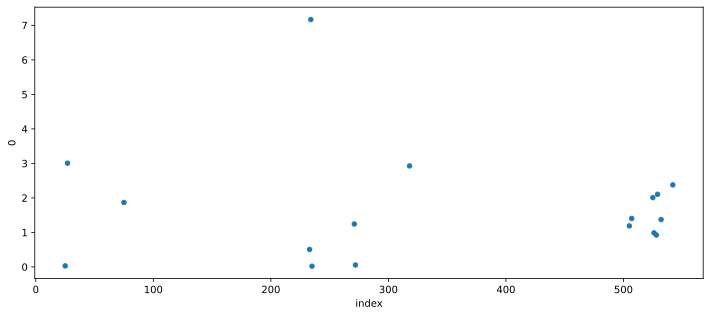

In [248]:
binding_energies_at_starting_positions.to_frame().reset_index().plot.scatter(x='index', y=0)

In [252]:
# plot it as overlapping windows like below

# find other TFs likely to bind the SPI1 promoter, scan those, make plot like below.

# make some code that turns something like the above into a bigWig and uploads it to ResGen

# Scan key sequences with MOODS with my PWMs. And/or write my own PWM scanning code (copy from Nina class?)

# find a credible absolute energy of binding for every TF: maybe by DBD family?


# ---------

# What do I actually need to do now?

# get a regulatory region. Scan all the probound motifs and newly converted energy motifs

# get all the ChIP peaks that overlap the regulatory region

# make a way to plot
# - the ChIP datasets
# - the ProBound binding energy tracks
# - the old fashioned motif binding energy tracks

# I need to be able to use my tool to make predictions about binding

# for that I need nucleosome energies and MCMC up and running

# Do I want a bed file or a bigwig?


# ---------

# I have the HepG2 ATAC and RNA. I can plot those as well.

Let's now proceed to a slightly more complex regulatory region, with 20 binding sites for 10 TFs




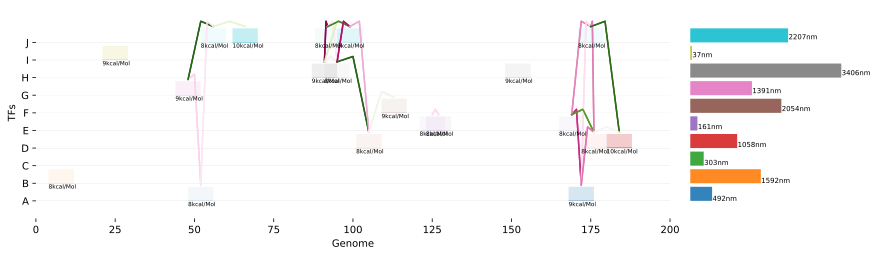

In [157]:
#collapse
# draw our model regulatory region:

TFs, TF_conc, TFBSs, cooperativities = create_environment(len_DNA=200, num_TFs=10, num_TFBS=20)

ax = draw_config(TFBSs, TF_conc, cooperativities, len_DNA=200)
plt.tight_layout()

Notice first that when binding sites overlap slightly, we've introduced a free energy penalty of competition, denoted by a pink line between the binding sites, and when they stronly overlap, we've disallowed those configurations, denoted by a red line. 

We notice a problem with evaluating our $p_\mathrm{config}$ expression with realistic regulatory DNA: the number of configurations grows exponentially in the number of transcription factor binding sites ($2^{|\mathrm{TFBS}|}$). Only 20 Transcription Factor Binding sites entails ~1 million configurations, and so ~1 million terms in the denominator $Z$. Computing probabilities of configurations exactly then becomes intractable for realistic scenarios: we need to proceed by sampling. 

<!-- In the MCMC approach, we only need to evaluate numerators, i.e. the un-normalized probabilities of configurations. It's worth noting here that the computational effort involved is already substantial: the number of terms in the expression for the weight of a macrostate grows ~linearly with the number of TFBS, which could grow quite large.  -->

Thankfully there's a dynamic programming approach to computing Z. 

In [57]:
config = np.round(np.random.rand(len(TFBSs))).astype(int)

Which we can plot, and compute the associated log-statistical-weight:

log(p_config) = -1.4748275325663975


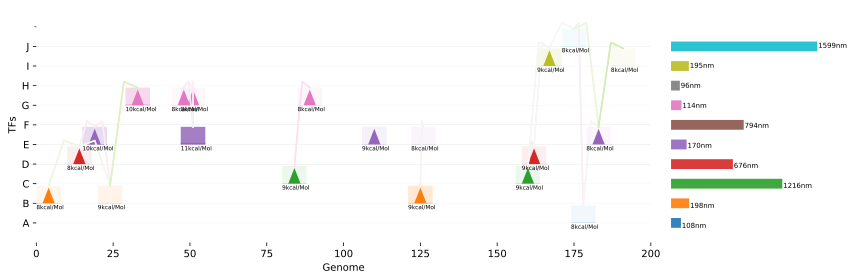

In [58]:
axs = draw_config(config)
plt.tight_layout()
print('log(p_config) =', log_P_config(config))

**References**
- [Calculating transcription factor binding maps for chromatin](https://academic.oup.com/bib/article/13/2/187/253754)

## Multiple TFs: Nucleosome-mediated Cooperativity

Direct cooperativity (driven by protein-protein interactions) between transcription factors exerts significant control over transcription when it occurs, but it appears to be the exception, not the rule. More common is indirect cooperativity mediated by nucleosomes. Nucleosomes can be thought of as repressive transcription factors with large footprints and relatively non-specific sequence-dependent binding affinities. When multiple transcription factors bind independently in the footprint of a nucleosome, they do so cooperatively, despite not making physical contact with one another.

Including nucleosomes in our description of chromatin produces a new set of interactions, which require energy parameters. Those are: 
- Nucleosome:DNA interactions
- Nucleosome:TF interactions
- Nucleosome:Nucleosome interactions

#### Nucleosome:DNA 

> Nucleosomes have at least a 5000-fold range of affinities for differing DNA sequences.

[What controls nucleosome positions?](https://www.sciencedirect.com/science/article/pii/S0168952509001243?via%3Dihub)

Nucleosomes do not bind specific 147-bp sequences, but they do have preferences for certain periodic patterns, and disfavor certain other patterns. Nucleosomes are canonically wrapped by 147bp of DNA, but due to nucleosome crowding and nucleosome beathing, they are often wrapped by fewer bases. 

For our model, we will say that any stretch of DNA [of lengths 100-147bp] can be wrapped by a nucleosome, with an energy which is derived from the [sequence model here]. 



In [12]:
def nucleosome_energy_from_sequence(sequence):
    '''
    tells you the binding energy
    '''
    pass

In [ ]:
# we'll say there are particular nucleotides where the nucleosome binding energy is really good, everywhere else it's okay

#### Nucleosome:TF

Nucleosomes and Transcription Factors were considered to sterically block one another from binding the same stretch of DNA, however, we now know that many TFs can co-bind DNA and stabilize nucleosomal binding to a piece of DNA. 

For simplicity, we'll assume we're only considering transcription factors which cannot co-bind DNA with nucleosomes, and impose a large ΔG penalty for nucleosome and TF co-binding.



#### Nucleosome:Nucleosome

Nucleosomes are spaced by stretches of free DNA called linker DNA, which have characterisitic lengths. Those specific lengths are believed to facilitate nucleosome arrays forming higher-order chromatin structures. 

In [11]:
def energy_of_spacing_between_nucleosomes(nucleosome_positions):
    '''
    '''
    pass

In [22]:
nanomolar_kd_from_kcal_ΔG(23.8*kbT)

0.04610959744808222

In [25]:
nanomolar_kd_from_kcal_ΔG(14.4*kbT)

557.3903692694596

send blog post for feedback:
- Jeremy / Leonid
- Advait / Bin Zhang
- Anders
- Kellis lab
- Vlad Teif, other online nucleosome people
- TF people?
- Muir Morrison / Rob Philips

### transfer matrix: probably won't use

In [ ]:
# Goal here is to form a transfer matrix

# the PWMs are concatenated head to tail on the y/i axis (and expanded ACGT). The next base is on the x/j axis: there are 4 values in the row.

# the start of each motif is that value * concentration

# I need hypothetical absolute max kd's ΔG's. Then everything is relative to that. Does the transfer matrix sum energies or something else?

# how does the particular sequence enter the matrix multiplication? You're choosing a path through the matrix.
# Does that mean the matrix at each base is different? Or there are 4 matrices again?
# yeah I think there have to be 4 matrices (or 6 if you include methylation). Wait since matrices are for each pair of positions, we need 16 acctually?





In [189]:
sum(tfdb.log_pwm.apply(len))

12757

TFAP2A                                               ... TP73       \
              0    1    2    3    4    5    6    7    8    9   ...   9    10   
TFAP2A 0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
TP73   14    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       15    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       16    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       17    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       18    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

                                                   
            11   12   13   14   15   16   17   18  
TFAP2A 0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...        ...  ...  ...  ...  ...  ...  ...  ...  
TP73   14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[12757 rows x 12757 columns]

In [228]:
# transfer_matrix_a = pd.DataFrame.sparse.from_spmatrix(csr_matrix(np.zeros((len(tf_states), len(tf_states)))), index=tf_states, columns=tf_states)

transfer_matrix_a = np.zeros((len(tf_states), len(tf_states)))
# transfer_matrix_c = np.zeros((len(tf_states), len(tf_states)))
# transfer_matrix_g = np.zeros((len(tf_states), len(tf_states)))
# transfer_matrix_t = np.zeros((len(tf_states), len(tf_states)))

In [191]:
tfdb.log_pwm

TFAP2A    [[-0.5324, 0.34450000000000003, -1.5585, 0.530...
TFAP2B    [[-2.4892, 0.5962000000000001, 1.0115, -2.6127...
TFAP2C    [[-0.5975, -0.163, -1.1323, 0.7243], [-1.3232,...
TFAP2D    [[0.8455, -1.4861, 0.1063, -1.8089], [-5.6699,...
TFAP2E    [[-5.6699, 0.43660000000000004, 1.1706, -5.669...
                                ...                        
BATF3     [[-0.8147000000000001, 0.11900000000000001, 0....
CREB1     [[-0.049100000000000005, -0.20500000000000002,...
TP53      [[0.1729, -0.6791, 0.6519, -0.661], [0.7944, -...
TP63      [[-0.5391, -1.3228, 1.0218, -0.394300000000000...
TP73      [[0.08610000000000001, -0.6413, 0.738200000000...
Name: log_pwm, Length: 1080, dtype: object

In [230]:
base_index = {'a':0,'c':1,'g':2,'t':3}


In [207]:
tf_states = pd.Index([(tf, i) for tf, log_pwm in tfdb.log_pwm.items() for i in range(len(log_pwm))])

In [227]:
def transfer_matrix_index(TF, offset): return tf_states.get_loc((TF, offset))

In [231]:
for TF, pwm in tfdb.log_pwm.items():
    for offset, row in enumerate(pwm):

        i = transfer_matrix_index(TF, offset)

        transfer_matrix_a[i][i+1] = pwm[offset][base_index['a']]


IndexError: index 12757 is out of bounds for axis 0 with size 12757